## Interpolate out Gaps in SST Data

In [1]:
#libraries
import datetime as dt
import xarray as xr
import numpy as np
import fsspec
import s3fs
import os.path
import matplotlib.pyplot as plt

# make datasets display nicely
xr.set_options(display_style="html")  

#magic fncts #put static images of your plot embedded in the notebook
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 


#### pull in data from the zarr store

In [2]:
%%time

file_location = 's3://ohw-bucket/goes_east'

ikey = fsspec.get_mapper(file_location,anon=False)

ds = xr.open_zarr(ikey) #,consolidated=True)

ds

CPU times: user 2.1 s, sys: 68.9 ms, total: 2.16 s
Wall time: 10.1 s


,Array,Chunk
Bytes,16.95 GB,117.68 MB
Shape,"(144, 5424, 5424)","(1, 5424, 5424)"
Count,145 Tasks,144 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,16.95 GB,117.68 MB
Shape,"(144, 5424, 5424)","(1, 5424, 5424)"
Count,145 Tasks,144 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


Just visualize how cloudy various parts of the ocean are

In [3]:
# sum up all the times DFQ isn't 0
#gs_subset = ds.sel(x=slice(-0.012,0.012),y=slice(0.12,0.085))  #reduce to GS region
gs_subset = ds.isel(time=slice(0,36))
masked = gs_subset.where(gs_subset.DQF!=3)
masked = masked.where(masked.DQF!=2)
sum_gaps = masked.DQF.sum('time',skipna=True)   #here I want all possible values so skipna=True
sum_gaps = sum_gaps.where(gs_subset.isel(time=0).DQF!=3)
#sum_gaps = sum_gaps.where(gs_subset.isel(time=0).DQF!=2)

In [4]:
sum_gaps

<xarray.DataArray 'DQF' (y: 5424, x: 5424)>
dask.array<where, shape=(5424, 5424), dtype=float32, chunksize=(5424, 5424), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 -0.151844 -0.151788 -0.151732 ... 0.151788 0.151844
  * y        (y) float32 0.151844 0.151788 0.151732 ... -0.151788 -0.151844
    time     datetime64[ns] 2020-06-28T00:30:06.396018048

In [ ]:
plt.ioff()

fig, ax = plt.subplots(figsize=(9.5,8))

# plot it
sum_gaps.plot(vmax=6, cmap='jet', ax=ax)
ax.axis('off')
plt.savefig('total_cloud_cover.png', dpi=200)

plt.close(fig)

Cut it down to the first 24 time steps around the Gulf Stream just to be more manageable

In [3]:
ds_subset = ds.isel(time=slice(0,24))
ds_subset

<xarray.Dataset>
Dimensions:                                                 (SST_day_night_emissive_bands: 4, SST_night_only_emissive_band: 1, number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_time_bounds: 2, time: 24, x: 5424, y: 5424)
Coordinates:
  * time                                                    (time) datetime64[ns] ...
  * x                                                       (x) float32 -0.15...
  * y                                                       (y) float32 0.151...
Dimensions without coordinates: SST_day_night_emissive_bands, SST_night_only_emissive_band, number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_time_bounds
Data variables:
    DQF                                                     (time, y, x) float32 dask.array<chunksize=(1, 5424, 5424), meta=np.ndarray>
    SST                                                     (time, y, x) float32 dask.array<chunksize=(1, 5424, 5424), meta=np.ndarray>
    SST_day_night_emissive_band_ids                         (SST_day_night_emissive_bands) int8 dask.array<chunksize=(4,), meta=np.ndarray>
    SST_day_night_emissive_wavelengths                      (SST_day_night_emissive_bands) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    SST_night_only_emissive_band_id                         (SST_night_only_emissive_band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    SST_night_only_emissive_wavelength                      (SST_night_only_emissive_band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    algorithm_dynamic_input_data_container                  (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    algorithm_product_version_container                     (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    day_solar_zenith_angle                                  float32 ...
    day_solar_zenith_angle_bounds                           (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    geospatial_lat_lon_extent                               (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    goes_imager_projection                                  (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    max_obs_modeled_diff_SST_night_only_emissive_band       (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    max_retrieved_Reynolds_SST_diff                         (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    maximum_sea_surface_temp                                (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    mean_obs_modeled_diff_SST_night_only_emissive_band      (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    mean_retrieved_Reynolds_SST_diff                        (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    mean_sea_surface_temp                                   (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    min_obs_modeled_diff_SST_night_only_emissive_band       (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    min_retrieved_Reynolds_SST_diff                         (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    minimum_sea_surface_temp                                (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    night_solar_zenith_angle                                float32 ...
    night_solar_zenith_angle_bounds                         (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    nominal_satellite_height                                (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    nominal_satellite_subpoint_lat                          (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    nominal_satellite_subpoint_lon                          (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    number_of_day_SST_pixels                                (time) float64 dask.arra

In [4]:
gs_subset = ds_subset.sel(x=slice(0.0,0.020),y=slice(0.110,0.090))  #reduce to GS region
masked = gs_subset.SST.where(gs_subset.DQF==0)
mean_SST = masked.mean('time') 
mean_SST

<xarray.DataArray 'SST' (y: 357, x: 357)>
dask.array<mean_agg-aggregate, shape=(357, 357), dtype=float32, chunksize=(357, 357), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 2.8014183e-05 8.401275e-05 ... 0.019908011 0.01996401
  * y        (y) float32 0.109956 0.1099 0.109844 ... 0.090076 0.09001999

Now pull out a bunch of random samples just because it takes forever otherwise

In [5]:
import random
num_samples = 300

ys = random.choices(range(1, mean_SST.y.shape[0]-1), k=num_samples)
xs = random.choices(range(1, mean_SST.x.shape[0]-1), k=num_samples)

In [6]:
#x_locs = np.repeat(gs_subset.x.values[:, np.newaxis], gs_subset.y.shape, axis=1).flatten()
x_locs = mean_SST.x[xs]
#y_locs = np.repeat(gs_subset.y.values[:, np.newaxis], gs_subset.x.shape, axis=1).flatten()
y_locs = mean_SST.y[ys]
#data_flat = gs_subset.SST.values.flatten()
data_flat = mean_SST.values[xs,ys]

#x_locs.shape, y_locs.shape, data_flat.shape
len(x_locs), len(y_locs), len(data_flat)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(300, 300, 300)

In [7]:
krige_data = np.array([x_locs,y_locs, data_flat])
krige_data.shape

(3, 300)

Do we have any nans?

In [8]:
np.isnan(data_flat).any()

True

Cut out any samples that are nan

In [9]:
krige_data = krige_data[:,~np.isnan(krige_data).any(axis=0)]
krige_data.shape

(3, 286)

In [10]:
from pykrige.uk import UniversalKriging
import numpy as np

gridx = gs_subset.x.values
gridy = gs_subset.y.values

# Create the ordinary kriging object. Required inputs are the X-coordinates of
# the data points, the Y-coordinates of the data points, and the Z-values of the
# data points. Variogram is handled as in the ordinary kriging case.
# drift_terms is a list of the drift terms to include; currently supported terms
# are 'regional_linear', 'point_log', and 'external_Z'. Refer to
# UniversalKriging.__doc__ for more information.
UK = UniversalKriging(krige_data[0,:], krige_data[1,:], krige_data[2,:], variogram_model='exponential',
                      drift_terms=['regional_linear'], nlags=20)

# Creates the kriged grid and the variance grid. Allows for kriging on a rectangular
# grid of points, on a masked rectangular grid of points, or with arbitrary points.
# (See UniversalKriging.__doc__ for more information.)
z, ss = UK.execute('grid', gridx, gridy)

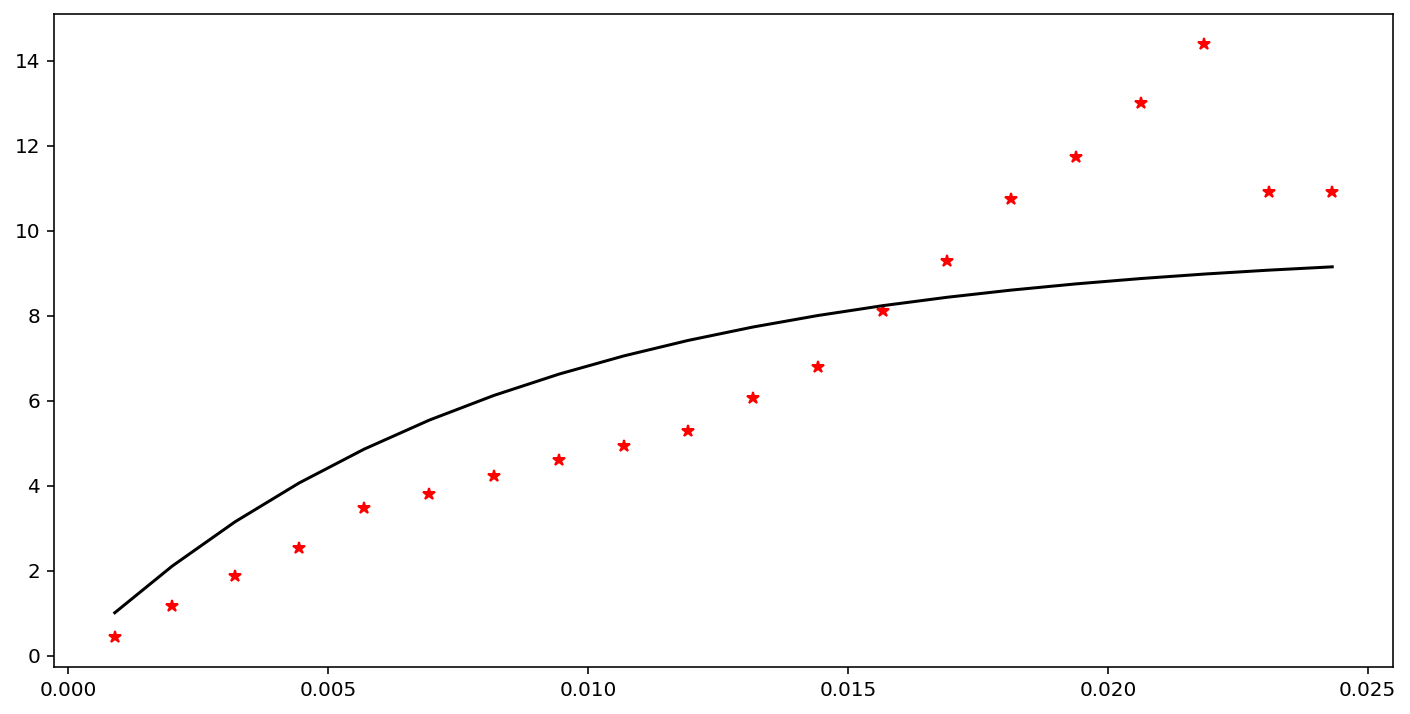

In [11]:
UK.display_variogram_model()

In [12]:
np.min(z), np.max(z)

(290.44372558593494, 301.79827880853895)

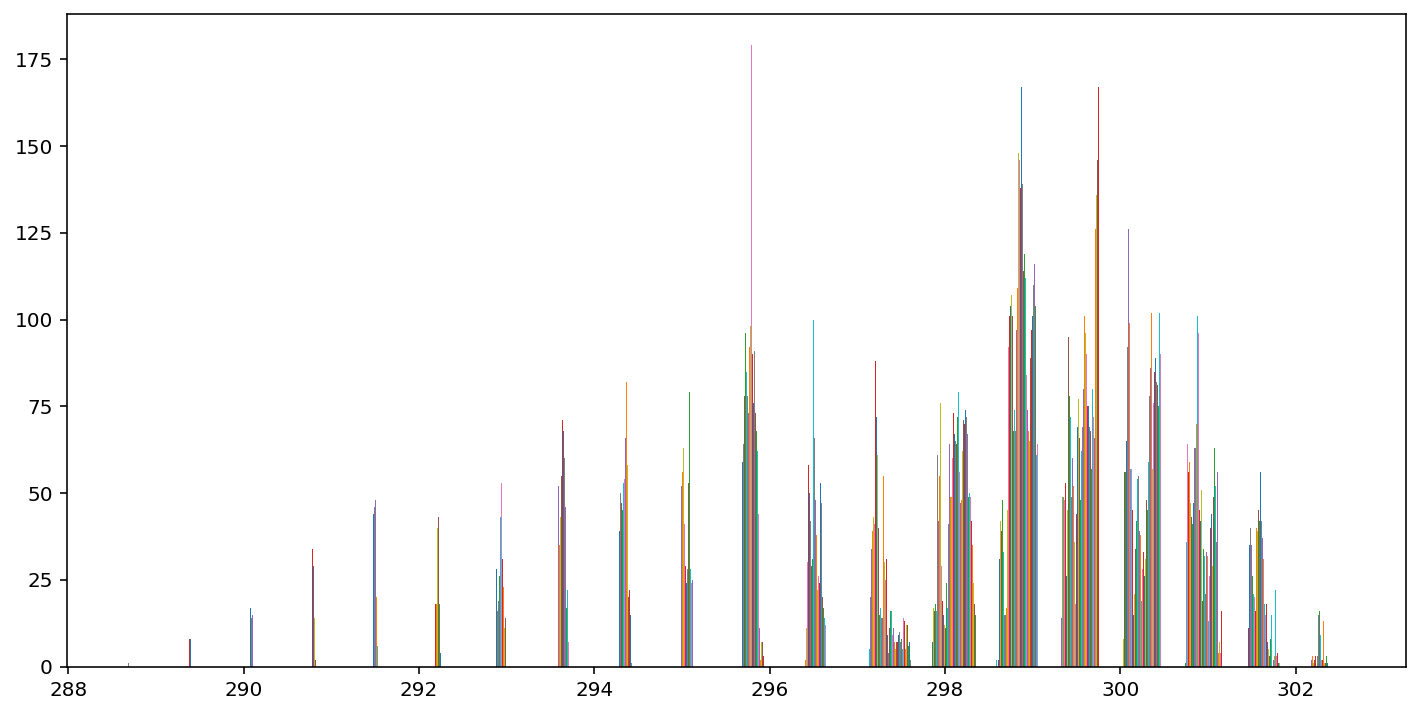

In [41]:
plt.hist(z, bins=20)
plt.show()

What does our interpolated SST map look like?

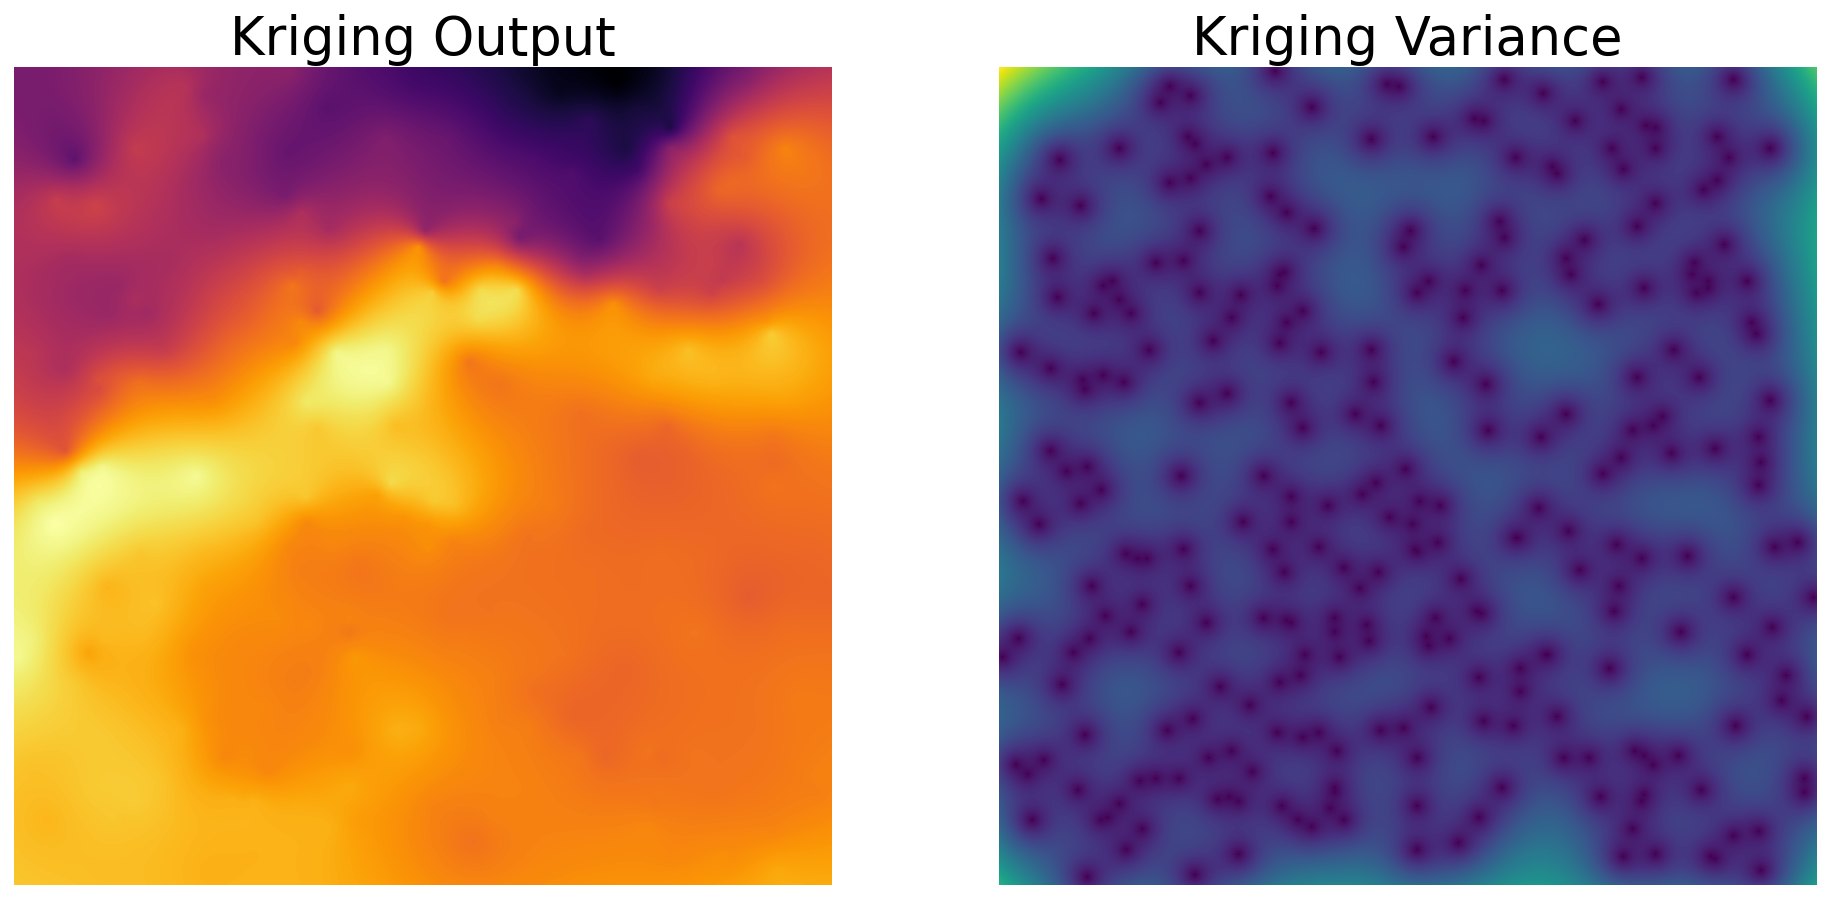

In [24]:
plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(1,2, figsize=(14,7))

plt.tight_layout()

# #mean_SST.plot(ax=ax[0],cmap='inferno', add_colorbar=False)
# ax[0].imshow(mean_SST, cmap='inferno')
# #plt.colorbar(im1, ax=ax[0])
# ax[0].set_title('Original Data')
# ax[0].axis('off')

im1 = ax[0].imshow(z.T, cmap='inferno')
#plt.colorbar(im1, ax=ax[1])
ax[0].set_title('Kriging Output')
ax[0].axis('off')

im2 = ax[1].imshow(ss.T)
ax[1].set_title('Kriging Variance')
ax[1].axis('off')
#plt.colorbar(im2, ax=ax[2])

plt.savefig('kriging_output.png')

What does variance look like?

How does the interpolated SST compare?

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


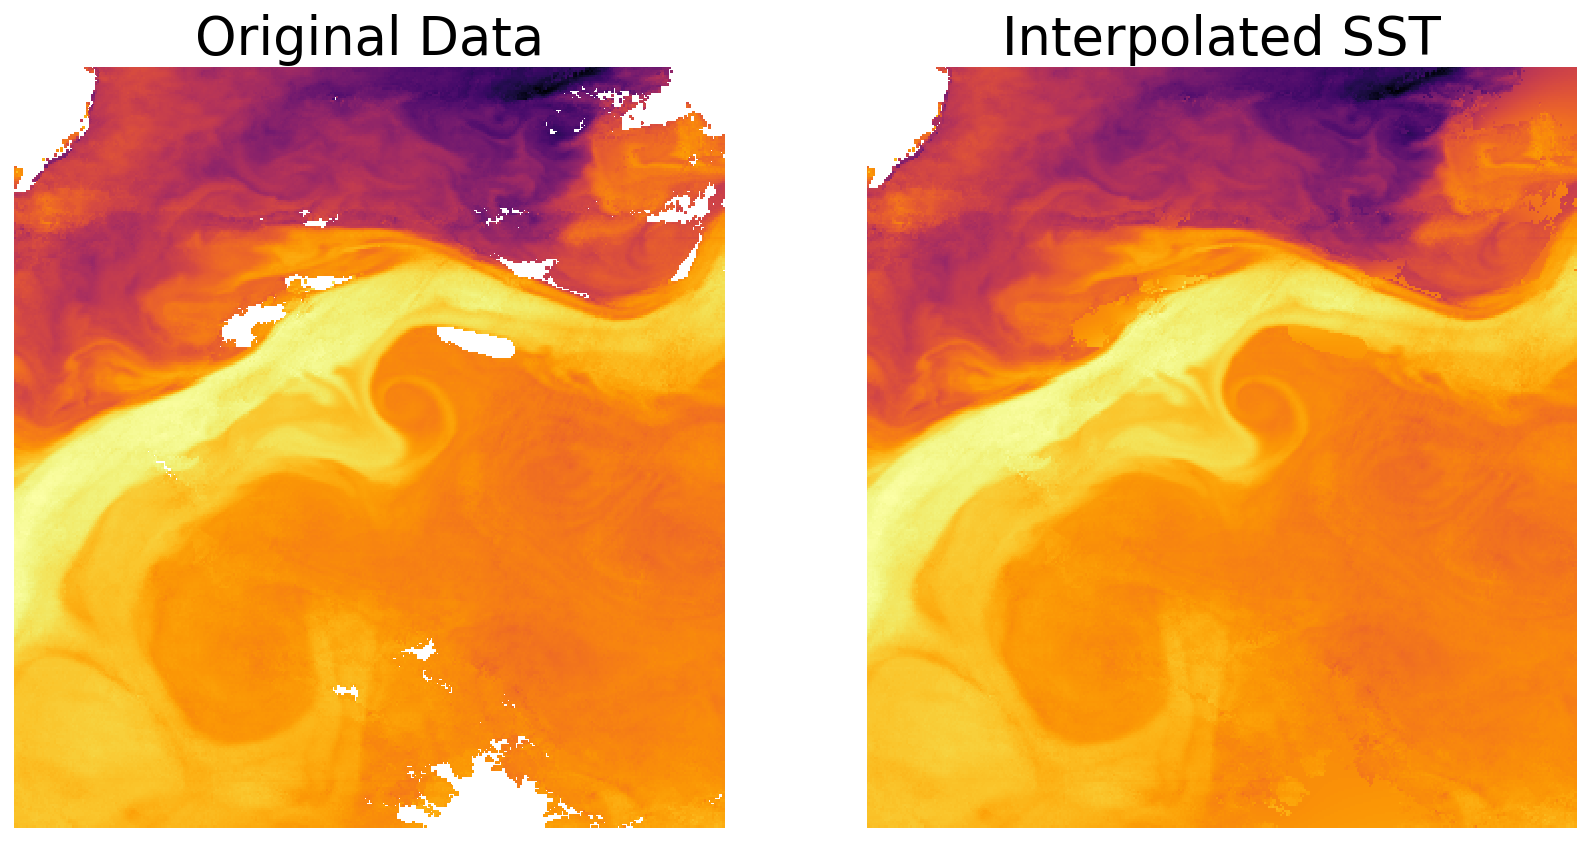

In [25]:
plt.rcParams.update({'font.size': 22})

filled = mean_SST.fillna(z.T)

fig, ax = plt.subplots(1,2, figsize=(14,7))

mean_SST.plot(ax=ax[0],cmap='inferno', add_colorbar=False)
ax[0].axis('off')

# filled.plot(ax=ax[1],cmap='inferno', add_colorbar=False)
# ax[1].axis('off')

filled_masked = filled.where(gs_subset.isel(time=0).DQF!=3)
filled_masked.plot(ax=ax[1],cmap='inferno', add_colorbar=False)
ax[1].axis('off')

ax[0].set_title('Original Data')
ax[1].set_title('Interpolated SST')
#ax[2].set_title('Interp and Masked SST')

plt.savefig('interpolation_output.png')

### Not terrible... but we need the time component

In [139]:
#mean_dy = masked.mean('time',skipna=True)   #here I want all possible values so skipna=True
ds_resamp = ds.resample(time="6H").mean(skipna=True)
ds_resamp

<xarray.Dataset>
Dimensions:                                                 (SST_day_night_emissive_bands: 4, SST_night_only_emissive_band: 1, number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, time: 24, x: 5424, y: 5424)
Coordinates:
  * time                                                    (time) datetime64[ns] ...
  * y                                                       (y) float32 0.151...
  * x                                                       (x) float32 -0.15...
Dimensions without coordinates: SST_day_night_emissive_bands, SST_night_only_emissive_band, number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds
Data variables:
    DQF                                                     (time, y, x) float32 dask.array<chunksize=(1, 5424, 5424), meta=np.ndarray>
    SST                                                     (time, y, x) float32 dask.array<chunksize=(1, 5424, 5424), meta=np.ndarray>
    SST_day_night_emissive_band_ids                         (time, SST_day_night_emissive_bands) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    SST_day_night_emissive_wavelengths                      (time, SST_day_night_emissive_bands) float32 dask.array<chunksize=(1, 4), meta=np.ndarray>
    SST_night_only_emissive_band_id                         (time, SST_night_only_emissive_band) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SST_night_only_emissive_wavelength                      (time, SST_night_only_emissive_band) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    algorithm_dynamic_input_data_container                  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    algorithm_product_version_container                     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    day_solar_zenith_angle                                  (time) float32 85...
    day_solar_zenith_angle_bounds                           (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    geospatial_lat_lon_extent                               (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    goes_imager_projection                                  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    max_obs_modeled_diff_SST_night_only_emissive_band       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    max_retrieved_Reynolds_SST_diff                         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    maximum_sea_surface_temp                                (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mean_obs_modeled_diff_SST_night_only_emissive_band      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mean_retrieved_Reynolds_SST_diff                        (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mean_sea_surface_temp                                   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    min_obs_modeled_diff_SST_night_only_emissive_band       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    min_retrieved_Reynolds_SST_diff                         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    minimum_sea_surface_temp                                (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    night_solar_zenith_angle                                (time) float32 95...
    night_solar_zenith_angle_bounds                         (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    nominal_satellite_height                                (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    nominal_satellite_subpoint_lat                          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    nominal_satellite_subpoint_lon                          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    number_of_day_SST_pixels                                (time) float64 dask.array<c

In [140]:
gs_subset

<xarray.Dataset>
Dimensions:                                                 (SST_day_night_emissive_bands: 4, SST_night_only_emissive_band: 1, number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, time: 12, x: 179, y: 179)
Coordinates:
  * time                                                    (time) datetime64[ns] ...
  * y                                                       (y) float32 0.104...
  * x                                                       (x) float32 0.005...
Dimensions without coordinates: SST_day_night_emissive_bands, SST_night_only_emissive_band, number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds
Data variables:
    DQF                                                     (time, y, x) float32 dask.array<chunksize=(1, 179, 179), meta=np.ndarray>
    SST                                                     (time, y, x) float32 dask.array<chunksize=(1, 179, 179), meta=np.ndarray>
    SST_day_night_emissive_band_ids                         (time, SST_day_night_emissive_bands) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
    SST_day_night_emissive_wavelengths                      (time, SST_day_night_emissive_bands) float32 dask.array<chunksize=(1, 4), meta=np.ndarray>
    SST_night_only_emissive_band_id                         (time, SST_night_only_emissive_band) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SST_night_only_emissive_wavelength                      (time, SST_night_only_emissive_band) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    algorithm_dynamic_input_data_container                  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    algorithm_product_version_container                     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    day_solar_zenith_angle                                  (time) float32 85...
    day_solar_zenith_angle_bounds                           (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    geospatial_lat_lon_extent                               (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    goes_imager_projection                                  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    max_obs_modeled_diff_SST_night_only_emissive_band       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    max_retrieved_Reynolds_SST_diff                         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    maximum_sea_surface_temp                                (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mean_obs_modeled_diff_SST_night_only_emissive_band      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mean_retrieved_Reynolds_SST_diff                        (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mean_sea_surface_temp                                   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    min_obs_modeled_diff_SST_night_only_emissive_band       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    min_retrieved_Reynolds_SST_diff                         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    minimum_sea_surface_temp                                (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    night_solar_zenith_angle                                (time) float32 95...
    night_solar_zenith_angle_bounds                         (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    nominal_satellite_height                                (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    nominal_satellite_subpoint_lat                          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    nominal_satellite_subpoint_lon                          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    number_of_day_SST_pixels                                (time) float64 dask.array<chunksi

In [150]:
ds

,Array,Chunk
Bytes,16.95 GB,117.68 MB
Shape,"(144, 5424, 5424)","(1, 5424, 5424)"
Count,145 Tasks,144 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,16.95 GB,117.68 MB
Shape,"(144, 5424, 5424)","(1, 5424, 5424)"
Count,145 Tasks,144 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [ ]:
ds_subset = ds.isel(time=slice(0,50))
gs_subset = ds_subset.sel(x=slice(0.005,0.015),y=slice(0.105,0.095))  #reduce to GS region
masked = gs_subset.SST.where(gs_subset.DQF==0)
masked.mean('time',skipna=True).plot()

In [141]:
ds_subset = ds_resamp.isel(time=slice(0,12))
gs_subset = ds_subset.sel(x=slice(0.005,0.015),y=slice(0.105,0.095))  #reduce to GS region
masked = gs_subset.SST.where(gs_subset.DQF==0)
#masked = masked.isel(time=slice(1))
masked.load()
masked

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'SST' (time: 12, y: 179, x: 179)>
array([[[296.52963, 296.66962, 296.8784 , ...,       nan,       nan,
               nan],
        [296.30667, 296.44217, 296.5931 , ...,       nan,       nan,
               nan],
        [296.0588 , 296.11697, 296.31967, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[298.04874, 298.04468, 298.00558, ...,       nan,       nan,
               nan],
        [298.10162, 298.01007, 298.03244, ...,       nan,       nan,
               nan],
        [298.07028, 297.97995, 298.02023, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-28 ... 2020-06-30T18:00:00
  * y        (y) float32 0.10497199 0.10491599 ... 0.09505999 0.09500399
  * x        (x) float32 0.0050120056 0.005068004 ... 0.014924005 0.014980003

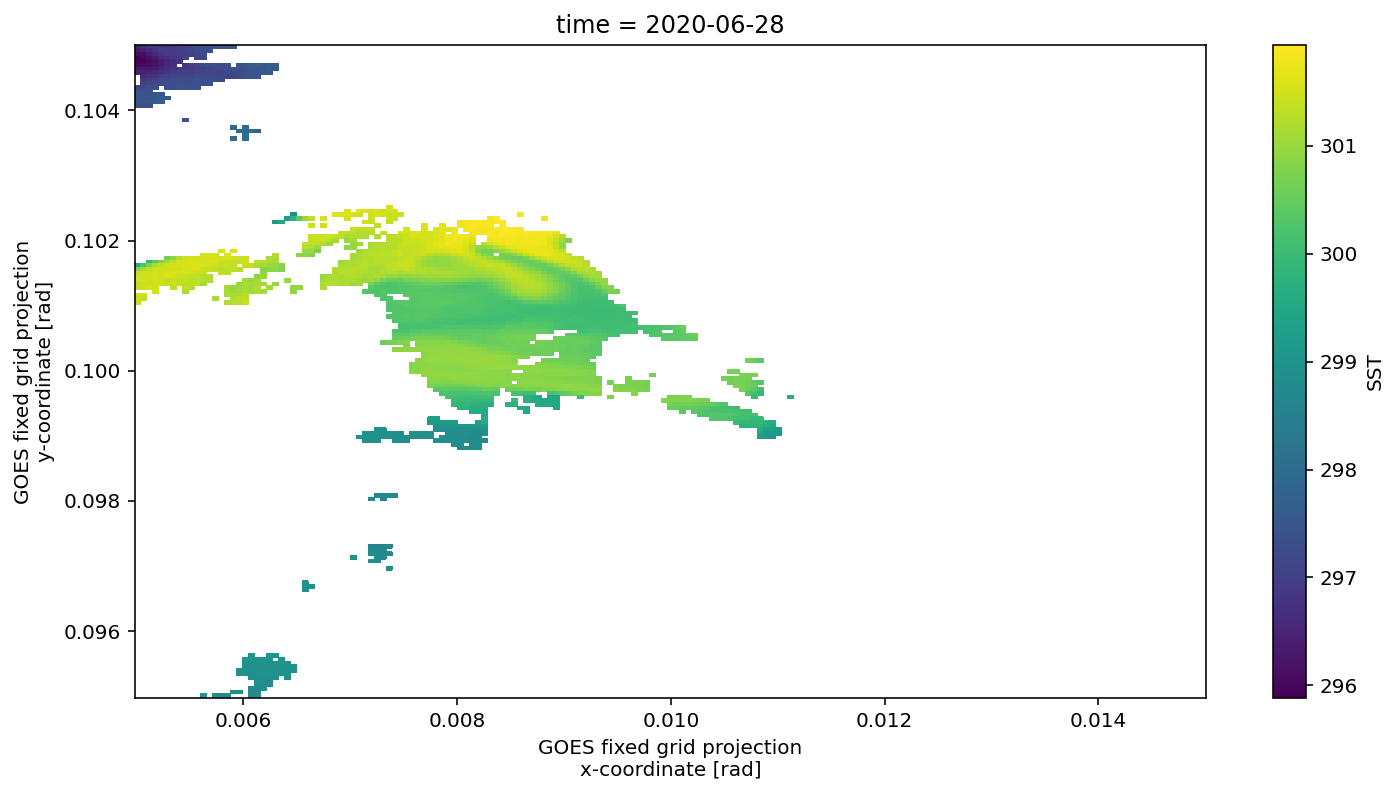

In [144]:
masked[0].plot()

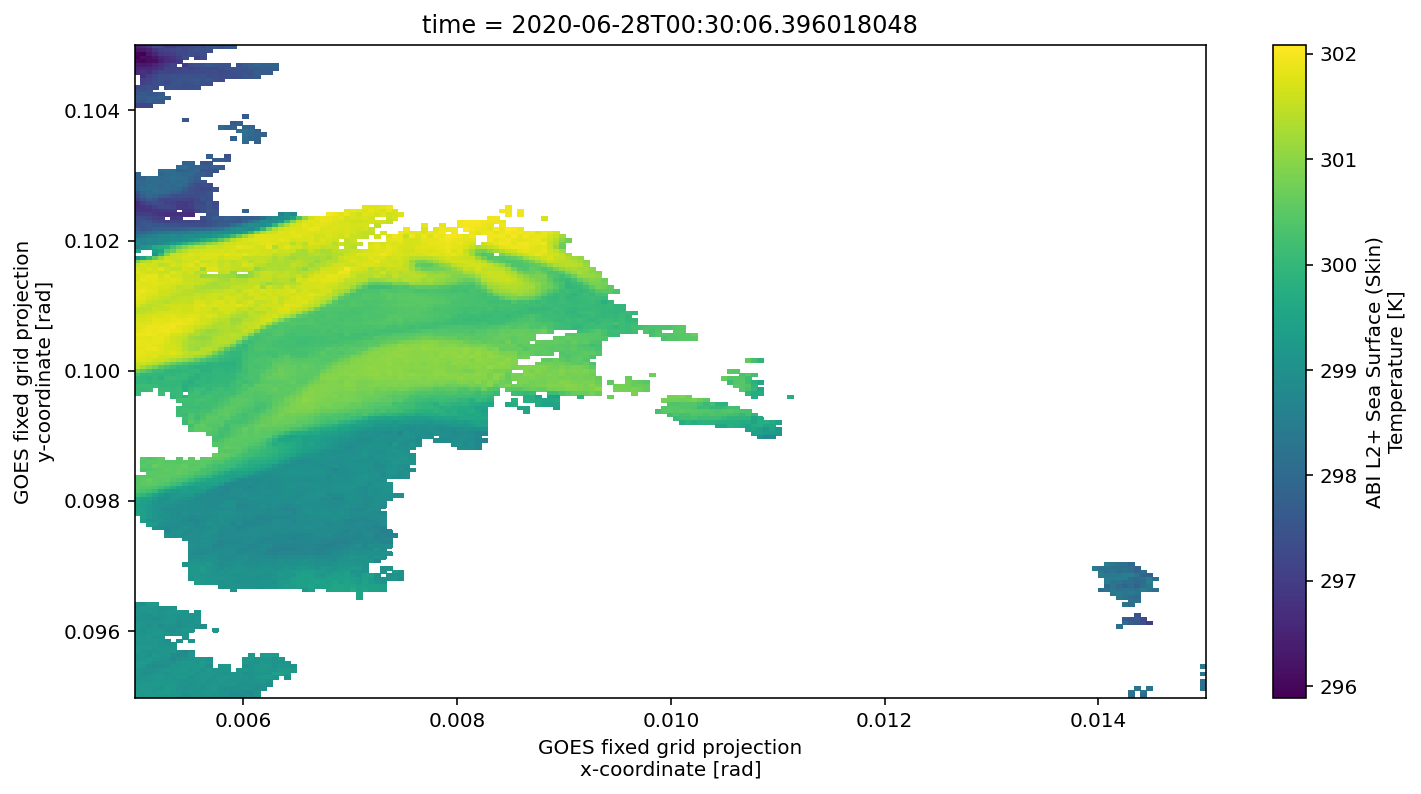

In [124]:
masked[0].plot()

In [115]:
import random
num_samples = 500

ys = random.choices(range(0, masked.y.shape[0]), k=num_samples)
xs = random.choices(range(0, masked.x.shape[0]), k=num_samples)
ts = random.choices(range(0, masked.time.shape[0]), k=num_samples)

#x_locs = np.repeat(gs_subset.x.values[:, np.newaxis], gs_subset.y.shape, axis=1).flatten()
#x_locs = masked.x[xs]
x_locs = xs

#y_locs = np.repeat(gs_subset.y.values[:, np.newaxis], gs_subset.x.shape, axis=1).flatten()
#y_locs = masked.y[ys]
y_locs = ys

#t_locs = np.array(masked.time[ts], dtype='datetime64[h]').astype('long')
t_locs = np.multiply(ts, 10)

#data_flat = gs_subset.SST.values.flatten()
data_flat = masked.values[ts,xs,ys]

#x_locs.shape, y_locs.shape, data_flat.shape
len(t_locs), len(x_locs), len(y_locs), len(data_flat)

(500, 500, 500, 500)

In [116]:
krige_data = np.array([x_locs,y_locs,t_locs,data_flat])
krige_data.shape

(4, 500)

In [117]:
np.isnan(data_flat).any()

True

In [118]:
krige_data = krige_data[:,~np.isnan(krige_data).any(axis=0)]
krige_data.shape

(4, 59)

In [108]:
from pykrige.ok3d import OrdinaryKriging3D
from pykrige.uk3d import UniversalKriging3D
import numpy as np

gridx = np.array(range(0, masked.x.shape[0])).astype(np.float64)
gridy = np.array(range(0, masked.y.shape[0])).astype(np.float64)
gridt = np.array(range(0, masked.time.shape[0])).astype(np.float64) * 10

# Create the 3D ordinary kriging object and solves for the three-dimension kriged
# volume and variance. Refer to OrdinaryKriging3D.__doc__ for more information.
# ok3d = OrdinaryKriging3D(krige_data[:, 0], krige_data[:, 1], krige_data[:, 2], krige_data[:, 3],
#                                                  variogram_model='linear')
# k3d, ss3d = ok3d.execute('grid', gridx, gridy, gridt)

# # Create the 3D universal kriging object and solves for the three-dimension kriged
# # volume and variance. Refer to UniversalKriging3D.__doc__ for more information.
uk3d = UniversalKriging3D(krige_data[0,:], krige_data[1,:], krige_data[2,:], krige_data[3,:],
                                                  variogram_model='exponential', nlags=10)

In [109]:
%%time
k3d, ss3d = uk3d.execute('grid', gridx, gridy, gridt, backend='loop')

CPU times: user 17.6 s, sys: 439 ms, total: 18 s
Wall time: 16.9 s


In [33]:
%%time
k3d, ss3d = uk3d.execute('masked', gridx, gridy, gridt, backend='loop', mask=(~np.isnan(masked).values).T)

CPU times: user 7min 22s, sys: 8min 30s, total: 15min 52s
Wall time: 4min 1s


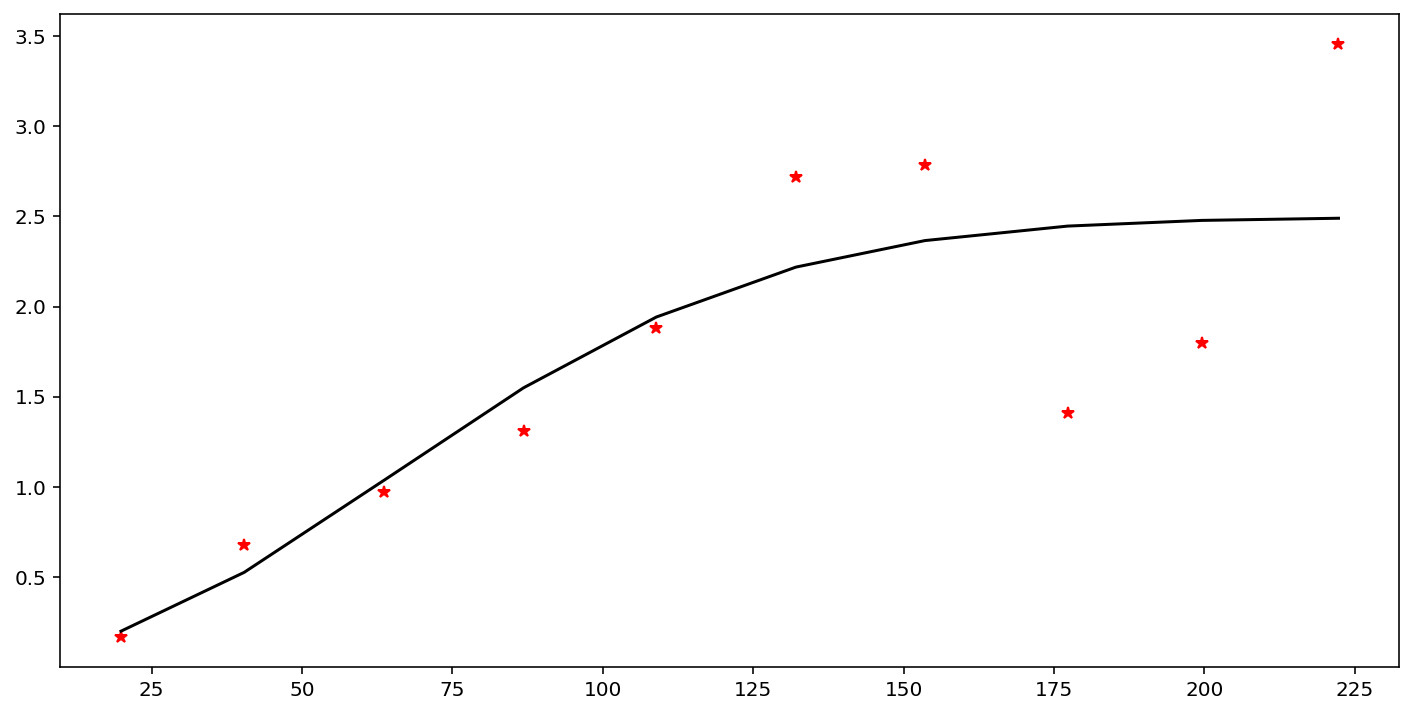

In [110]:
uk3d.display_variogram_model()

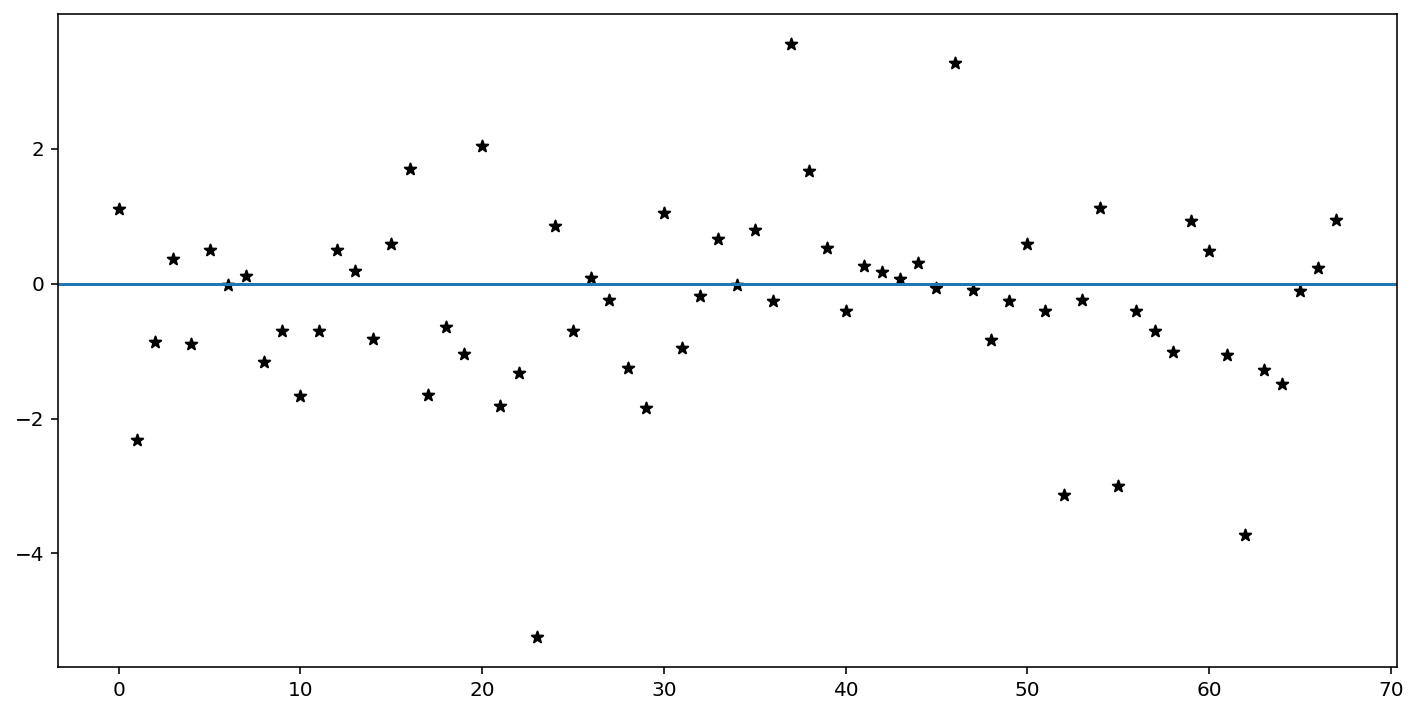

In [111]:
uk3d.plot_epsilon_residuals()

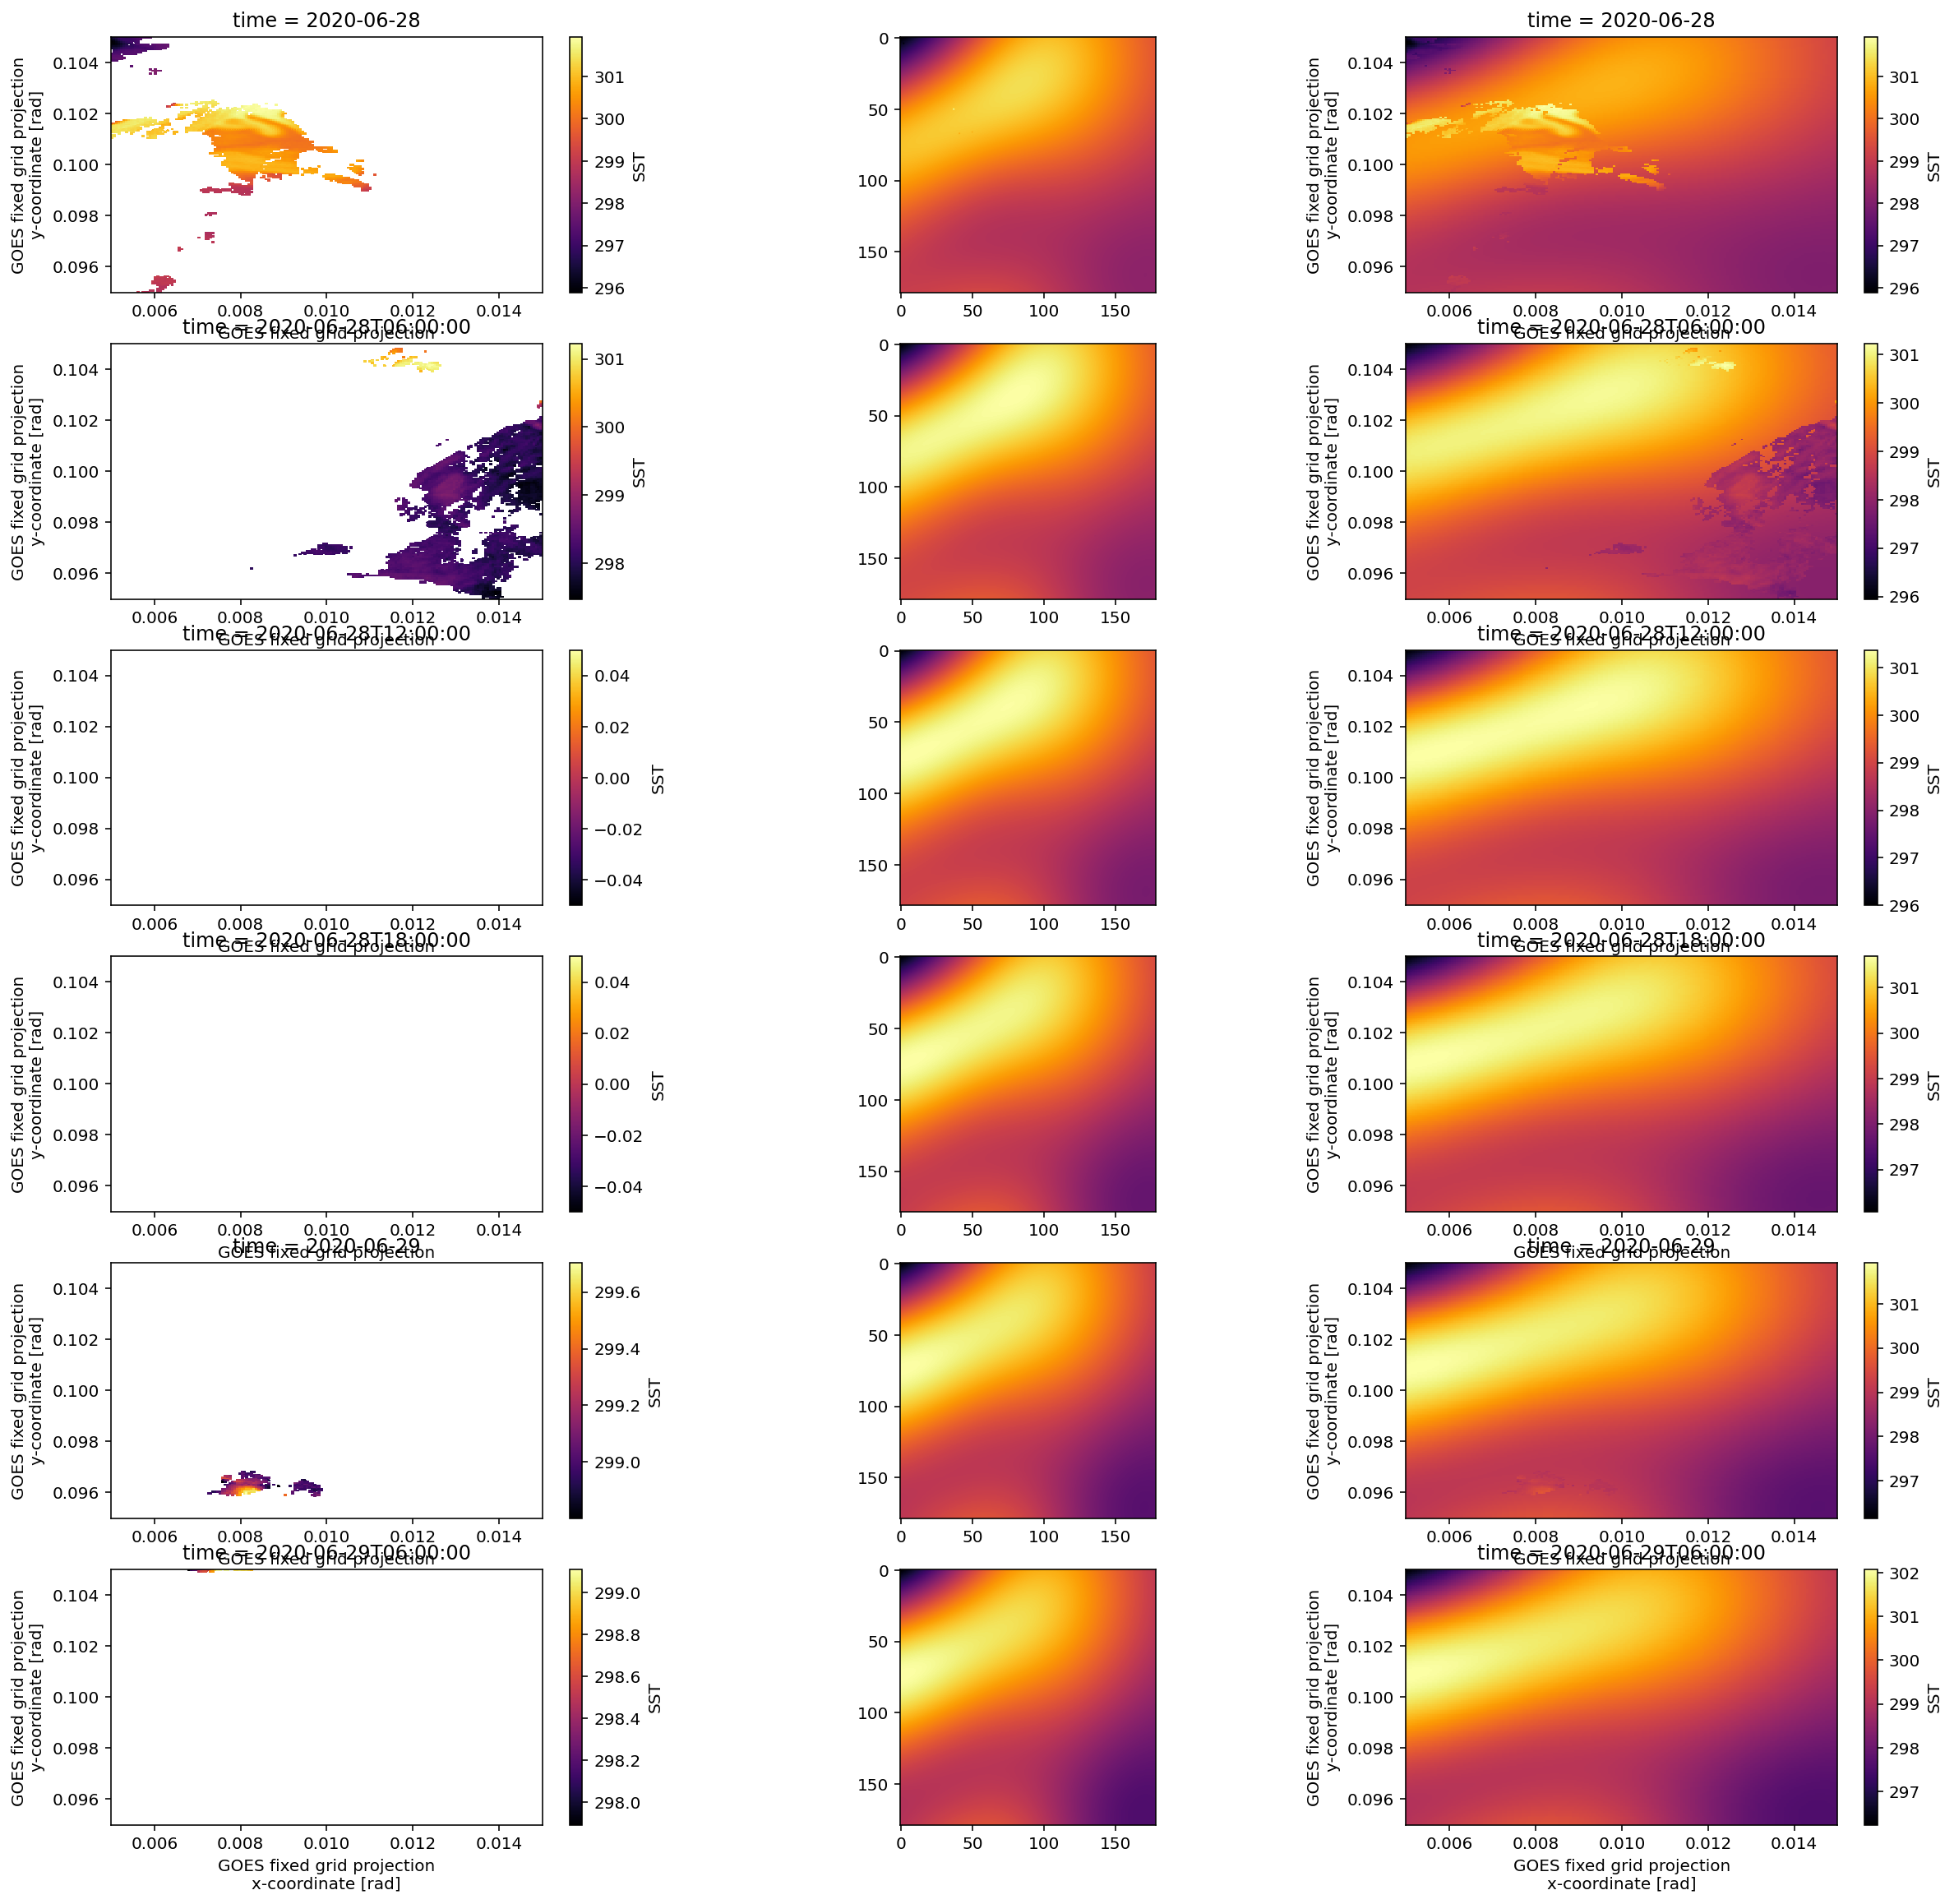

In [112]:
time_step = 4

fig, ax = plt.subplots(6,3, figsize=(20,20))

for time_step in range(6):

    masked[time_step].plot(ax=ax[time_step,0],cmap='inferno')

    ax[time_step,1].imshow(k3d[time_step].T, cmap='inferno')

    filled = masked[time_step].fillna(k3d[time_step].T)

    filled.plot(ax=ax[time_step,2],cmap='inferno')

    #filled_masked = filled.where(gs_subset.isel(time=0).DQF!=3)
    #filled_masked.plot(ax=ax[2],cmap='inferno')

    #ax[0].set_title('Original SST')
    #ax[1].set_title('Interpolated SST')
    #ax[2].set_title('Interp and Masked SST')

### Make a .gif lookking at variability of the GS